In [17]:
%pip install fiftyone
# 1. Imports & Setup
import os
import sys
import json
import time
import math
import glob
import random
import copy
import shutil
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler

import fiftyone as fo
import fiftyone.zoo as foz

# Set Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("✅ Notebook Updated: Version 3.0 (Fixed Collate & Criterion)")





Using device: cuda
✅ Notebook Updated: Version 3.0 (Fixed Collate & Criterion)


In [18]:
# 2. Configuration
# --- USER SETTINGS ---
QUICK_TEST = True  # Set to True for a fast smoke test
BATCH_SIZE = 1000 if QUICK_TEST else 2000  # Images per "roll"
NUM_BATCHES = 1 if QUICK_TEST else 10    # How many times to roll
EPOCHS_PER_BATCH = 1 if QUICK_TEST else 2 # Epochs to train on each batch

BASE_DIR = os.path.abspath("yolo-lab")
DIRS = {
    "datasets": os.path.join(BASE_DIR, "datasets"),
    "runs": os.path.join(BASE_DIR, "runs"),
    "configs": os.path.join(BASE_DIR, "configs"),
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
EXP_NAME = "yolov8_local_batch"
RUN_NAME = f"{timestamp}_{EXP_NAME}"
RUN_DIR = os.path.join(DIRS["runs"], RUN_NAME)
os.makedirs(RUN_DIR, exist_ok=True)

# Model & Training Config
CFG = {
    "exp_name": EXP_NAME,
    "run_name": RUN_NAME,
    "seed": 42,
    "imgsz": 640,
    "batch_size": 8 if QUICK_TEST else 16,
    "num_classes": 80,
    
    # Model
    "width": 1.0,
    "depth": 1.0,
    "reg_max": 16,
    "head_hidden": 256,
    "backbone": "yolov8_cspdarknet",
    
    # Optimizer
    "optimizer": "adamw",
    "lr": 1e-3,
    "weight_decay": 0.05,
    "cosine_schedule": True,
    "epochs": EPOCHS_PER_BATCH, # Per batch
    "amp": True,
    "grad_clip_norm": 10.0,
    "ema_decay": 0.9998,
    
    # Loss
    "tal_alpha": 1.0,
    "tal_beta": 6.0,
    "tal_topk": 10,
    "tal_center_radius": 2.5,
    "loss_weights": {"box": 7.5, "cls": 0.5, "dfl": 1.5}, # Adjusted for v8
    
    # Augmentation
    "letterbox_pad": 114,
    "hflip_p": 0.5,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    
    # Paths (Dynamic per batch)
    "data_root": os.path.join(DIRS["datasets"], "current_batch"),
    "train_img_dir": "images/train",
    "train_lbl_dir": "labels/train",
    "val_img_dir": "images/val",
    "val_lbl_dir": "labels/val",
}

print("Run Directory:", RUN_DIR)


Run Directory: /content/yolo-lab/runs/20251231_171419_yolov8_local_batch


In [19]:
# 3. Model Architecture
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):
        super().__init__()
        if p is None: p = k // 2
        self.conv = nn.Conv2d(c1, c2, k, s, p, groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class Bottleneck(nn.Module):
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):
        super().__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2
    def forward(self, x): return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class C2f(nn.Module):
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):
        super().__init__()
        self.c = int(c2 * e)
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3)), e=1.0) for _ in range(n))
    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

class SPPF(nn.Module):
    def __init__(self, c1, c2, k=5):
        super().__init__()
        c_ = c1 // 2
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
    def forward(self, x):
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)
        return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))

class CSPDarknet(nn.Module):
    def __init__(self, width=1.0, depth=1.0):
        super().__init__()
        base_c = [64, 128, 256, 512, 1024]
        base_d = [3, 6, 6, 3]
        self.c = [int(x * width) for x in base_c]
        self.d = [max(round(x * depth), 1) if x > 1 else x for x in base_d]
        self.stem = Conv(3, self.c[0], 3, 2)
        self.stage1 = nn.Sequential(Conv(self.c[0], self.c[1], 3, 2), C2f(self.c[1], self.c[1], n=self.d[0], shortcut=True))
        self.stage2 = nn.Sequential(Conv(self.c[1], self.c[2], 3, 2), C2f(self.c[2], self.c[2], n=self.d[1], shortcut=True))
        self.stage3 = nn.Sequential(Conv(self.c[2], self.c[3], 3, 2), C2f(self.c[3], self.c[3], n=self.d[2], shortcut=True))
        self.stage4 = nn.Sequential(Conv(self.c[3], self.c[4], 3, 2), C2f(self.c[4], self.c[4], n=self.d[3], shortcut=True), SPPF(self.c[4], self.c[4], k=5))

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        c3 = self.stage2(x)
        c4 = self.stage3(c3)
        c5 = self.stage4(c4)
        return c3, c4, c5

class YOLOv8PAFPN(nn.Module):
    def __init__(self, c3, c4, c5, out_ch=256, width=1.0, depth=1.0):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.reduce5 = Conv(c5, c4, 1, 1)
        self.c2f_p4 = C2f(c4 + c4, c4, n=3, shortcut=False)
        self.reduce4 = Conv(c4, c3, 1, 1)
        self.c2f_p3 = C2f(c3 + c3, c3, n=3, shortcut=False)
        self.down3 = Conv(c3, c3, 3, 2)
        self.c2f_n4 = C2f(c3 + c4, c4, n=3, shortcut=False)
        self.down4 = Conv(c4, c4, 3, 2)
        self.c2f_n5 = C2f(c4 + c5, c5, n=3, shortcut=False)

    def forward(self, c3, c4, c5):
        p5 = c5
        p4 = self.reduce5(p5)
        p4_out = self.c2f_p4(torch.cat([self.up(p4), c4], dim=1))
        p3 = self.reduce4(p4_out)
        p3_out = self.c2f_p3(torch.cat([self.up(p3), c3], dim=1))
        n3 = p3_out
        n4_out = self.c2f_n4(torch.cat([self.down3(n3), p4_out], dim=1))
        n5_out = self.c2f_n5(torch.cat([self.down4(n4_out), p5], dim=1))
        return n3, n4_out, n5_out

class Integral(nn.Module):
    def __init__(self, reg_max=16):
        super().__init__()
        self.reg_max = int(reg_max)
        self.register_buffer("proj", torch.arange(self.reg_max + 1, dtype=torch.float32), persistent=False)
    def forward(self, logits):
        return (logits.softmax(dim=-1) * self.proj).sum(dim=-1)

class YoloV8LiteHead(nn.Module):
    def __init__(self, in_channels_list, num_classes=80, hidden=256, reg_max=16):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max = reg_max
        self.integral = Integral(self.reg_max)
        self.cls_towers = nn.ModuleList()
        self.reg_towers = nn.ModuleList()
        self.cls_preds = nn.ModuleList()
        self.box_preds = nn.ModuleList()
        
        for in_ch in in_channels_list:
            self.cls_towers.append(nn.Sequential(Conv(in_ch, hidden, 3, 1), Conv(hidden, hidden, 3, 1)))
            self.reg_towers.append(nn.Sequential(Conv(in_ch, hidden, 3, 1), Conv(hidden, hidden, 3, 1)))
            self.cls_preds.append(nn.Conv2d(hidden, num_classes, 1))
            self.box_preds.append(nn.Conv2d(hidden, 4 * (self.reg_max + 1), 1))
            
        self.init_weights()

    def init_weights(self):
        # Bias Init: p=0.01 -> bias approx -4.6
        bias = -4.595
        for m in self.cls_preds:
             nn.init.constant_(m.bias, bias)

    def forward(self, features):
        cls_outs = []
        box_outs = []
        for i, f in enumerate(features):
            cls_outs.append(self.cls_preds[i](self.cls_towers[i](f)))
            box_outs.append(self.box_preds[i](self.reg_towers[i](f)))
        return cls_outs, box_outs

class YoloModel(nn.Module):
    def __init__(self, num_classes=80, backbone="yolov8_cspdarknet", head_hidden=256, fpn_out=256):
        super().__init__()
        width = CFG.get("width", 1.0)
        depth = CFG.get("depth", 1.0)
        self.backbone = CSPDarknet(width=width, depth=depth)
        base_c = [256, 512, 1024]
        c3, c4, c5 = [int(x * width) for x in base_c]
        self.neck = YOLOv8PAFPN(c3=c3, c4=c4, c5=c5, out_ch=fpn_out, width=width, depth=depth)
        self.head = YoloV8LiteHead(in_channels_list=[c3, c4, c5], num_classes=num_classes, hidden=head_hidden, reg_max=CFG.get("reg_max", 16))
        self.strides = [8, 16, 32]

    def forward(self, x, targets=None):
        c3, c4, c5 = self.backbone(x)
        p3, p4, p5 = self.neck(c3, c4, c5)
        cls_outs, box_outs = self.head([p3, p4, p5])
        head_out = {"features": [p3, p4, p5], "cls": cls_outs, "box": box_outs, "strides": self.strides}
        
        if self.training and targets is not None and hasattr(self, "criterion"):
            losses, stats = self.criterion(head_out, targets)
            return losses, stats
        return head_out


In [20]:
# 4. Utils & Loss
def make_grid(h, w, stride, device):
    ys = torch.arange(h, device=device)
    xs = torch.arange(w, device=device)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")
    cx = (xx + 0.5) * stride
    cy = (yy + 0.5) * stride
    return cx.reshape(-1), cy.reshape(-1)

def box_iou_xyxy_matrix(a, b):
    if a.numel() == 0 or b.numel() == 0: return a.new_zeros((a.shape[0], b.shape[0]))
    area_a = ((a[:, 2] - a[:, 0]).clamp(min=0) * (a[:, 3] - a[:, 1]).clamp(min=0))[:, None]
    area_b = ((b[:, 2] - b[:, 0]).clamp(min=0) * (b[:, 3] - b[:, 1]).clamp(min=0))[None, :]
    x1 = torch.maximum(a[:, None, 0], b[None, :, 0])
    y1 = torch.maximum(a[:, None, 1], b[None, :, 1])
    x2 = torch.minimum(a[:, None, 2], b[None, :, 2])
    y2 = torch.minimum(a[:, None, 3], b[None, :, 3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    return inter / (area_a + area_b - inter + 1e-6)

def bbox_iou(box1, box2, eps=1e-7):
    # box1: [N, 4], box2: [N, 4]
    b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
    union = w1 * h1 + w2 * h2 - inter + eps
    return inter / union

class DetectionLoss(nn.Module):
    def __init__(self, num_classes, image_size, strides, lambda_box=7.5, lambda_cls=0.5, lambda_dfl=1.5, dfl_ch=17):
        super().__init__()
        self.nc = num_classes
        self.imgsz = image_size
        self.strides = strides
        self.lambda_box = lambda_box
        self.lambda_cls = lambda_cls
        self.lambda_dfl = lambda_dfl
        self.dfl_ch = dfl_ch
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, head_out, targets):
        cls_outs = head_out["cls"]
        box_outs = head_out["box"]
        
        B = cls_outs[0].shape[0]
        
        pred_logits = [x.permute(0, 2, 3, 1).reshape(B, -1, self.nc) for x in cls_outs]
        preds_cls = torch.cat(pred_logits, dim=1) # [B, N_anchors, nc]
        
        pred_dist = [x.permute(0, 2, 3, 1).reshape(B, -1, 4 * self.dfl_ch) for x in box_outs]
        preds_box = torch.cat(pred_dist, dim=1) # [B, N_anchors, 4*dfl_ch]
        
        targets_per_image, levels = self.build_targets(cls_outs, box_outs, targets)
        
        loss_cls = torch.zeros(1, device=preds_cls.device)
        loss_box = torch.zeros(1, device=preds_cls.device)
        loss_dfl = torch.zeros(1, device=preds_cls.device)
        num_pos_total = 0.0
        target_scores_sum = 0.0
        
        # Vectorized Loss Calc
        # We construct full batch targets now instead of looping and re-allocating
        # However, due to variable num_pos, box loss is still easier to sum per image or use masking
        # But class loss can be vectorized if we build the target tensor efficiently
        
        # For Phase 1, we stick to loop but make it minimal and verify normalization
        
        for b in range(B):
            t = targets_per_image[b]
            pos_mask = t["pos_index"]
            num_pos = len(pos_mask)
            num_pos_total += num_pos
            
            if "target_scores_sum" in t:
                 target_scores_sum += t["target_scores_sum"]
            else:
                 target_scores_sum += num_pos # Fallback if hard

            # Classification Loss
            pred_cls_b = preds_cls[b] # [N_anchors, nc]
            t_cls = torch.zeros_like(pred_cls_b)
            if num_pos > 0:
                t_cls[pos_mask] = t["t_cls_soft"].to(t_cls.dtype)
            
            # BCE (vectorized over anchors)
            l_cls = self.bce(pred_cls_b, t_cls).sum()
            loss_cls += l_cls
            
            # Box Loss (IoU + DFL)
            if num_pos > 0:
                pred_box_dist_pos = preds_box[b][pos_mask] # [num_pos, 4*dfl_ch]
                pred_box_pos = pred_box_dist_pos.view(-1, 4, self.dfl_ch)
                
                anchor_strides = torch.empty(num_pos, device=preds_box.device, dtype=torch.float32)
                for level in levels:
                     start, end, s = level["start"], level["end"], level["stride"]
                     in_level = (pos_mask >= start) & (pos_mask < end)
                     if in_level.any():
                         anchor_strides[in_level] = float(s)
                
                t_box_ltrb_pixels = t["t_box_ltrb"]
                t_box_ltrb_bins = t_box_ltrb_pixels / anchor_strides.unsqueeze(-1)
                t_box_ltrb_bins = t_box_ltrb_bins.clamp(max=self.dfl_ch - 1.01)

                tl = t_box_ltrb_bins.long()
                tr = tl + 1
                wl = tr.float() - t_box_ltrb_bins
                wr = t_box_ltrb_bins - tl.float()
                
                l_dfl = (F.cross_entropy(pred_box_pos.view(-1, self.dfl_ch), tl.view(-1), reduction="none").view(-1, 4) * wl +
                         F.cross_entropy(pred_box_pos.view(-1, self.dfl_ch), tr.view(-1), reduction="none").view(-1, 4) * wr).mean(-1)
                loss_dfl += l_dfl.sum()

                anchors_cx, anchors_cy = [], []
                for level_i, level in enumerate(levels):
                    cx, cy = make_grid(level["H"], level["W"], level["stride"], preds_box.device)
                    anchors_cx.append(cx)
                    anchors_cy.append(cy)
                anchors_cx = torch.cat(anchors_cx)[pos_mask]
                anchors_cy = torch.cat(anchors_cy)[pos_mask]
                
                pred_ltrb_bins = (pred_box_pos.softmax(dim=-1) * torch.arange(self.dfl_ch, device=pred_box_pos.device).float()).sum(dim=-1)
                pred_ltrb_pixels = pred_ltrb_bins * anchor_strides.unsqueeze(-1)
                
                pred_x1 = anchors_cx - pred_ltrb_pixels[:, 0]
                pred_y1 = anchors_cy - pred_ltrb_pixels[:, 1]
                pred_x2 = anchors_cx + pred_ltrb_pixels[:, 2]
                pred_y2 = anchors_cy + pred_ltrb_pixels[:, 3]
                pred_xyxy = torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=-1)
                
                iou = bbox_iou(pred_xyxy, t["t_box_xyxy"])
                l_iou = 1.0 - iou
                loss_box += l_iou.sum()

        # Fix: Normalization by target scores sum
        norm = max(target_scores_sum, 1.0)
        loss_cls = (loss_cls * self.lambda_cls) / norm
        loss_box = (loss_box * self.lambda_box) / norm
        loss_dfl = (loss_dfl * self.lambda_dfl) / norm
        
        total = loss_cls + loss_box + loss_dfl
        return {"loss": total, "loss_cls": loss_cls, "loss_box": loss_box, "loss_dfl": loss_dfl}, {"num_pos": num_pos_total, "norm": norm}

    def build_targets(self, cls_outs, box_outs, targets):
        gt_classes = targets["labels"]
        gt_boxes = targets["boxes"]
        batch_idx = targets["batch_index"]
        B = cls_outs[0].shape[0]
        gt_cls_list = []
        gt_box_list = []
        for i in range(B):
            mask = batch_idx == i
            gt_cls_list.append(gt_classes[mask])
            gt_box_list.append(gt_boxes[mask])
        return build_targets_task_aligned(cls_outs, box_outs, self.strides, gt_cls_list, gt_box_list, self.imgsz)

def build_targets_task_aligned(cls_outs, box_outs, strides, gt_classes, gt_boxes_xyxy, image_size):
    device = cls_outs[0].device
    B = cls_outs[0].shape[0]
    C = cls_outs[0].shape[1]
    levels = []
    start = 0
    grids = []
    for (cl, s) in zip(cls_outs, strides):
        _, _, H, W = cl.shape
        levels.append({"H": H, "W": W, "stride": s, "start": start, "end": start + H * W})
        cx, cy = make_grid(H, W, s, device)
        grids.append((cx, cy))
        start += H * W
        
    # Using hardcoded TAL params for robustness
    tal_alpha, tal_beta, tal_topk, tal_cr = 0.5, 6.0, 10, 2.5
    
    per_image_targets = []
    for b in range(B):
        cls_per_image = [cl[b].permute(1, 2, 0).reshape(-1, C) for cl in cls_outs]
        cls_flat = torch.cat(cls_per_image, dim=0)
        N_total = cls_flat.shape[0]
        gtc = gt_classes[b]
        gtb = gt_boxes_xyxy[b]
        Ng = int(gtc.numel())
        if Ng == 0:
            per_image_targets.append({"t_cls_soft": torch.zeros(0, C, device=device), "t_box_xyxy": torch.zeros(0, 4, device=device), "t_box_ltrb": torch.zeros(0, 4, device=device), "pos_index": torch.zeros(0, dtype=torch.long, device=device), "target_scores_sum": 0.0})
            continue
        
        # ... (Same projection code) ...
        pred_xyxy_levels = []
        for (bx, level, (cx, cy)) in zip(box_outs, levels, grids):
            H, W, s = level["H"], level["W"], level["stride"]
            bl = bx[b]
            M1 = bl.shape[0] // 4
            bl = bl.view(4, M1, H, W).permute(2, 3, 0, 1).reshape(H * W, 4, M1)
            probs = bl.softmax(dim=-1)
            proj = torch.arange(M1, device=device, dtype=bl.dtype)
            dists = (probs * proj).sum(dim=-1) * float(s)
            x1, y1 = cx - dists[:, 0], cy - dists[:, 1]
            x2, y2 = cx + dists[:, 2], cy + dists[:, 3]
            pred_xyxy_levels.append(torch.stack([x1, y1, x2, y2], dim=-1).clamp_(0, image_size))
        pred_xyxy = torch.cat(pred_xyxy_levels, dim=0)

        candidate_mask = torch.zeros(N_total, Ng, dtype=torch.bool, device=device)
        for level, (cx, cy) in enumerate(grids):
            start, end, s = levels[level]["start"], levels[level]["end"], levels[level]["stride"]
            Nl = end - start
            cxv, cyv = cx.view(Nl, 1), cy.view(Nl, 1)
            gt_centers = 0.5 * (gtb[:, :2] + gtb[:, 2:])
            half = tal_cr * s
            in_center = (cxv >= gt_centers[:, 0] - half) & (cyv >= gt_centers[:, 1] - half) & (cxv <= gt_centers[:, 0] + half) & (cyv <= gt_centers[:, 1] + half)
            candidate_mask[start:end] |= in_center
        
        cls_sigmoid = cls_flat.sigmoid()
        cls_gt_scores = cls_sigmoid[:, gtc]
        iou_matrix = box_iou_xyxy_matrix(pred_xyxy, gtb)
        align = (cls_gt_scores.clamp(min=1e-9).pow(tal_alpha)) * (iou_matrix.clamp(min=1e-9).pow(tal_beta))
        align = torch.where(candidate_mask, align, torch.full_like(align, -1e-9))
        
        k = min(tal_topk, align.shape[0])
        topk_scores, topk_index = torch.topk(align, k, dim=0)
        best_gt_per_pred = torch.full((N_total,), -1, dtype=torch.long, device=device)
        best_score_per_pred = torch.full((N_total,), -1e-9, dtype=align.dtype, device=device)
        for j in range(Ng):
            idx_j = topk_index[:, j]
            score_j = topk_scores[:, j]
            better = score_j > best_score_per_pred[idx_j]
            best_gt_per_pred[idx_j[better]] = j
            best_score_per_pred[idx_j[better]] = score_j[better]
            
        pos_mask = best_gt_per_pred >= 0
        pos_index = torch.nonzero(pos_mask, as_tuple=False).squeeze(1)
        
        if pos_index.numel() == 0:
            per_image_targets.append({"t_cls_soft": torch.zeros(0, C, device=device), "t_box_xyxy": torch.zeros(0, 4, device=device), "t_box_ltrb": torch.zeros(0, 4, device=device), "pos_index": pos_index, "target_scores_sum": 0.0})
            continue
            
        gt_index = best_gt_per_pred[pos_index]
        scores = best_score_per_pred[pos_index].clamp(min=0.0)
        t_cls_soft = torch.zeros(len(pos_index), C, device=device)
        t_cls_soft[torch.arange(len(pos_index)), gtc[gt_index]] = scores
        t_box_xyxy = gtb[gt_index]
        
        t_box_ltrb = torch.empty(len(pos_index), 4, device=device)
        for level_i, level in enumerate(levels):
            start, end, s = level["start"], level["end"], level["stride"]
            cx, cy = grids[level_i]
            in_level = (pos_index >= start) & (pos_index < end)
            if in_level.any():
                idx_l = pos_index[in_level] - start
                ct = torch.stack((cx[idx_l], cy[idx_l]), dim=-1)
                gs = gtb[gt_index[in_level]]
                t_box_ltrb[in_level] = torch.stack((ct[:,0]-gs[:,0], ct[:,1]-gs[:,1], gs[:,2]-ct[:,0], gs[:,3]-ct[:,1]), dim=-1).clamp(min=0, max=float(image_size))
        
        per_image_targets.append({
            "t_cls_soft": t_cls_soft,
            "t_box_xyxy": t_box_xyxy,
            "t_box_ltrb": t_box_ltrb,
            "pos_index": pos_index,
            "target_scores_sum": scores.sum().item()
        })
    return per_image_targets, levels


In [21]:
# 5. Dataset (Mosaic + Affine)
def random_perspective(im, targets=(), degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    height, width = im.shape[:2]
    
    # Center
    C = np.eye(3)
    C[0, 2] = -width / 2
    C[1, 2] = -height / 2
    
    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)
    P[2, 1] = random.uniform(-perspective, perspective)
    
    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)
    
    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)
    
    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height
    
    # Combined rotation matrix
    M = T @ S @ R @ P @ C
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():
        if perspective:
            im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(114, 114, 114))
        else:
            im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(114, 114, 114))
            
    # Transform targets
    n = len(targets)
    if n:
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ M.T  # transform
        xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine
        
        # Create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T
        
        # Clip
        new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
        new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)
        
        # Filter candidates
        i = box_candidates(targets[:, 1:5].T * s, new.T, area_thr=0.10) # 0.10 area thr
        targets = targets[i]
        targets[:, 1:5] = new[i]
        
    return im, targets

def box_candidates(box1, box2, wh_thr=2, ar_thr=100, area_thr=0.1, eps=1e-16):
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)

class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, imgsz=640, augment=True, pad_value=114):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.imgsz = imgsz
        self.augment = augment
        self.pad_value = pad_value
        
        # Scan files
        if os.path.isdir(image_dir):
            self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.png")))
        else:
             # Assume it's a list (not implemented fully here but safe fallback)
             self.image_paths = []
             
        self.label_paths = []
        for img_path in self.image_paths:
             base = os.path.basename(img_path)
             name = os.path.splitext(base)[0]
             lbl_path = os.path.join(self.label_dir, name + ".txt")
             self.label_paths.append(lbl_path)
        
    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, index):
        # Load and resize to imgsz with padding (letterbox style essentially but simpler here)
        path = self.image_paths[index]
        img = cv2.imread(path)
        if img is None:
             print(f"❌ Failed to load {path}")
             return np.full((self.imgsz, self.imgsz, 3), 114, dtype=np.uint8), (0, 0), (1, 1)
             
        h, w = img.shape[:2]
        r = min(self.imgsz / h, self.imgsz / w)
        new_h, new_w = int(h * r), int(w * r)
        resized = cv2.resize(img, (new_w, new_h))
        
        return resized, (h, w), (new_h, new_w)

    def load_mosaic(self, index):
        # YOLO Mosaic Augmentation
        labels4 = []
        s = self.imgsz
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in [-s // 2])  # mosaic center x, y
        indices = [index] + random.choices(range(len(self)), k=3)  # 3 additional images
        random.shuffle(indices)
        
        result_img = np.full((s * 2, s * 2, 3), self.pad_value, dtype=np.uint8)
        
        for i, idx in enumerate(indices):
            img, _, (h, w) = self.load_image(idx)
            
            # Place coordinates
            if i == 0:  # top left
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(yc + h, s * 2)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(yc + h, s * 2)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
                
            result_img[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
            
            # Labels
            lbl_path = self.label_paths[idx]
            if os.path.exists(lbl_path):
                 with open(lbl_path, "r") as f:
                     l = np.array([x.split() for x in f.read().strip().splitlines()], dtype=np.float32)
                 if len(l):
                     # xywh to xyxy
                     h_orig, w_orig = self.load_image(idx)[1] # get original size for norm
                     # Normalized xywh -> pixel xyxy
                     boxes = l[:, 1:5]
                     boxes[:, [0, 2]] *= w_orig
                     boxes[:, [1, 3]] *= h_orig
                     # Scale to current resized dims
                     scale_w = w / w_orig
                     scale_h = h / h_orig
                     boxes[:, [0, 2]] *= scale_w
                     boxes[:, [1, 3]] *= scale_h
                     
                     # Convert xywh to xyxy
                     b = boxes.copy()
                     b[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
                     b[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
                     b[:, 2] = boxes[:, 0] + boxes[:, 2] / 2
                     b[:, 3] = boxes[:, 1] + boxes[:, 3] / 2
                     boxes = b
                     
                     boxes[:, 0] += padw
                     boxes[:, 1] += padh
                     boxes[:, 2] += padw
                     boxes[:, 3] += padh
                     
                     l[:, 1:5] = boxes
                     labels4.append(l)
        
        if len(labels4):
            labels4 = np.concatenate(labels4, 0)
            np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])
        else:
            labels4 = np.zeros((0, 5))
            
        # Augment (Center Crop 640 from 1280 or Resize?)
        # We crop a random 640x640 patch or resize? Standard is resize+crop. 
        # For simplicity here: Resize result to imgsz
        final_img = cv2.resize(result_img, (self.imgsz, self.imgsz))
        # Adjust labels
        scale = self.imgsz / (2 * s)
        labels4[:, 1:] *= scale
        
        return final_img, labels4

    def __getitem__(self, index):
        if self.augment:
            # Mosaic
            img, labels = self.load_mosaic(index)
            # HSV (Optional - keep simple for now)
            # Affine
            img, labels = random_perspective(img, labels, border=(0, 0))
        else:
            # Standard Load (Validation)
            img, (h_o, w_o), (h, w) = self.load_image(index)
            # Letterbox padding if needed
            top = (self.imgsz - h) // 2
            left = (self.imgsz - w) // 2
            img = cv2.copyMakeBorder(img, top, self.imgsz-h-top, left, self.imgsz-w-left, cv2.BORDER_CONSTANT, value=(114, 114, 114))
            # Load Labels
            lbl_path = self.label_paths[index]
            labels = np.zeros((0, 5))
            if os.path.exists(lbl_path):
                 with open(lbl_path, "r") as f:
                     l = np.array([x.split() for x in f.read().strip().splitlines()], dtype=np.float32)
                 if len(l):
                     # Normalized xywh -> target xyxy (padded)
                     b = l[:, 1:5].copy()
                     b[:, 0] = l[:, 1] * w_o * (w/w_o) + left # x_center in new img
                     b[:, 1] = l[:, 2] * h_o * (h/h_o) + top
                     b[:, 2] = l[:, 3] * w_o * (w/w_o)
                     b[:, 3] = l[:, 4] * h_o * (h/h_o)
                     # xywh to xyxy
                     l[:, 1] = b[:, 0] - b[:, 2] / 2
                     l[:, 2] = b[:, 1] - b[:, 3] / 2
                     l[:, 3] = b[:, 0] + b[:, 2] / 2
                     l[:, 4] = b[:, 1] + b[:, 3] / 2
                     labels = l

        # Normalize & Torch
        img = img.transpose(2, 0, 1)[::-1] # BGR to RGB -> HWC to CHW
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).float() / 255.0
        
        num_targets = len(labels)
        if num_targets > 0:
            # Cls, x1, y1, x2, y2
            out_labels = torch.from_numpy(labels[:, 0])
            out_boxes = torch.from_numpy(labels[:, 1:])
        else:
            out_labels = torch.zeros(0)
            out_boxes = torch.zeros(0, 4)
            
        return img, {"labels": out_labels, "boxes": out_boxes, "index": torch.tensor(index)}



In [22]:
# 6. Batch Management Logic
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def prepare_batch(batch_idx, size=2000):
    # Check for Quick Test Persistence
    if QUICK_TEST and os.path.exists(os.path.join(CFG["data_root"], "images/train")):
        print(f"\n⚡ QUICK_TEST mode: Found existing data at {CFG['data_root']}. Skipping download/export.")
        return None

    print(f"\n📦 Preparing Batch {batch_idx} (Size: {size})...")
    
    train_name = f"batch_{batch_idx}_train"
    val_name = f"batch_{batch_idx}_val"
    
    # 1. Safe Cleanup of Old Batches
    if fo.list_datasets():
        for name in fo.list_datasets():
            if name.startswith("batch_") and name != train_name and name != val_name:
                print(f"🧹 Deleting old dataset: {name}")
                fo.delete_dataset(name)
    
    for name in [train_name, val_name]:
        if name in fo.list_datasets():
            print(f"♻️  Deleting existing {name} to ensure fresh start")
            fo.delete_dataset(name)

    # 2. Download/Load from Zoo
    train_ds = foz.load_zoo_dataset(
        "coco-2017",
        split="train", 
        label_types=["detections"],
        max_samples=size,
        shuffle=True,
        seed=batch_idx * 999, 
        dataset_name=train_name,
        drop_existing=True 
    )

    val_ds = foz.load_zoo_dataset(
        "coco-2017",
        split="validation", 
        label_types=["detections"],
        max_samples=100 if size < 500 else 500,
        shuffle=True,
        seed=batch_idx * 999, 
        dataset_name=val_name,
        drop_existing=True 
    )
    
    # 3. Export to YOLO format
    out_dir = CFG["data_root"]
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir) 
        
    train_ds.export(
        export_dir=out_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="ground_truth",
        split="train",
        classes=COCO_CLASSES
    )
    
    val_ds.export(
        export_dir=out_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="ground_truth",
        split="val",
        classes=COCO_CLASSES
    )
    
    print(f"✅ Batch {batch_idx} exported to {out_dir}")
    return train_ds

def cleanup_batch(dataset):
    if QUICK_TEST:
        print("⚡ QUICK_TEST: Skipping cleanup to persist data for next run.")
        return

    print("🧹 Cleaning up batch...")
    if fo.list_datasets():
         for name in fo.list_datasets():
             if name.startswith("batch_"):
                 fo.delete_dataset(name)
                 
    if os.path.exists(CFG["data_root"]):
        shutil.rmtree(CFG["data_root"])
    print("✨ Cleanup complete.")


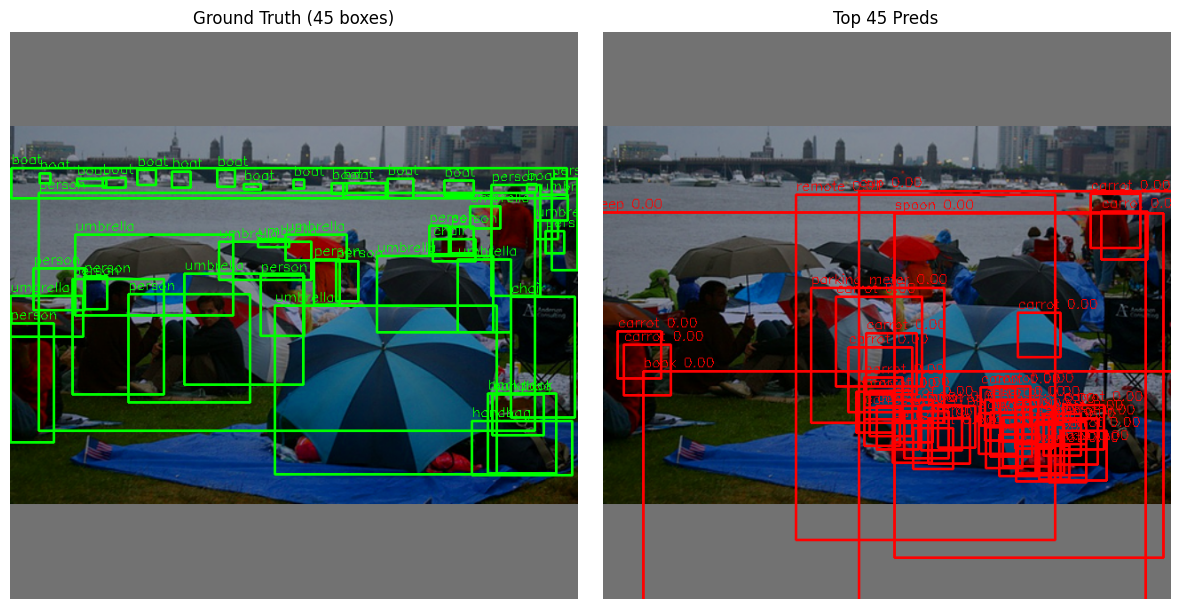

Batch 1 Ep 1 It 110: Loss 987.0679 (Box 985.8881 Cls 1.1799) Pos 556.0
Batch 1 Ep 1 It 120: Loss 1306.6851 (Box 1305.5190 Cls 1.1660) Pos 833.0
✅ Epoch 1 Complete. Avg Loss: 1016.4014 Avg Pos: 548.5
🎉 Batch 1 Complete!
🏁 Training Finished!


In [23]:
# 7. Main Execution Loop
import math
import time
from copy import deepcopy
import csv

# --- EMA ---
class ModelEMA:
    def __init__(self, model, decay=0.9999, tau=2000, updates=0):
        self.ema = deepcopy(model).eval()
        self.updates = updates
        self.decay = lambda x: decay * (1 - math.exp(-x / tau))
        for p in self.ema.parameters():
            p.requires_grad_(False)
    def update(self, model):
        self.updates += 1
        d = self.decay(self.updates)
        msd = model.state_dict()
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:
                v *= d
                v += (1 - d) * msd[k].detach()

state_file = os.path.join(DIRS["runs"], "checkpoint_state.json")
last_ckpt_path = os.path.join(RUN_DIR, "last.pt")
metrics_file = os.path.join(RUN_DIR, "metrics.csv")
start_time_global = time.time()
TIME_LIMIT = CFG.get("time_limit", 60 * 60) # Default 1 hour

# --- Initialization ---
model = YoloModel(num_classes=CFG["num_classes"]).to(device)
criterion = DetectionLoss(
    num_classes=CFG["num_classes"],
    image_size=CFG["imgsz"],
    strides=[8, 16, 32],
    lambda_box=CFG["loss_weights"]["box"],
    lambda_cls=CFG["loss_weights"]["cls"],
    lambda_dfl=CFG["loss_weights"].get("dfl", 1.5)
)
model.criterion = criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=5e-4)
scaler = GradScaler(enabled=CFG["amp"])
ema = ModelEMA(model)

lf = lambda x: (1 - x / CFG["epochs"]) * (1.0 - 0.1) + 0.1
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

# --- Resume Logic (Bulletproof) ---
start_batch = 0
start_epoch = 0
global_step = 0

if not QUICK_TEST and os.path.exists(last_ckpt_path):
    print(f"🔄 Resuming from {last_ckpt_path}")
    ckpt = torch.load(last_ckpt_path)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scaler.load_state_dict(ckpt["scaler"])
    if "scheduler" in ckpt:
        scheduler.load_state_dict(ckpt["scheduler"])
    if "ema" in ckpt:
         ema.ema.load_state_dict(ckpt["ema"])
         ema.updates = ckpt.get("ema_updates", 0)
    start_batch = ckpt.get("batch_idx", 0)
    start_epoch = ckpt.get("epoch", 0)
    global_step = ckpt.get("global_step", 0)
    
    # Handle batch completion boundary
    if ckpt.get("batch_complete", False):
         start_batch += 1
         start_epoch = 0
    print(f"   -> Batch: {start_batch}, Epoch: {start_epoch}, Step: {global_step}")

def save_checkpoint(path, batch_idx, epoch, step, complete=False):
    if QUICK_TEST: return
    torch.save({
        "model": model.state_dict(),
        "ema": ema.ema.state_dict(),
        "ema_updates": ema.updates,
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict(),
        "scheduler": scheduler.state_dict(),
        "batch_idx": batch_idx,
        "epoch": epoch,
        "global_step": step,
        "batch_complete": complete
    }, path)
    with open(state_file, "w") as f:
        json.dump({"batch_idx": batch_idx, "epoch": epoch, "global_step": step}, f)

# --- Evaluation & Validation ---
def compute_ap(recall, precision):
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def validate(model, loader, device, conf_thres=0.001):
    model.eval()
    stats = []
    print("\n🛡️ Validating...")
    iuv = torch.linspace(0.5, 0.95, 10, device=device)
    niou = iuv.numel()
    for batch_i, (imgs, targets) in enumerate(loader):
        imgs = imgs.to(device, non_blocking=True)
        batch_idx = targets["index"]
        with torch.no_grad():
            head_out = model(imgs)
            preds = decode_outputs(head_out, model.strides, conf_thres=conf_thres, max_det=300)
        for si, pred in enumerate(preds):
            gt_cls = targets["labels"][targets["batch_index"] == si]
            gt_box = targets["boxes"][targets["batch_index"] == si]
            nl = len(gt_cls)
            tcls = gt_cls.tolist() if nl else []
            if len(pred) == 0:
                if nl: stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue
            if nl:
                correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device=device)
                iou = bbox_iou(pred[:, :4], gt_box)
                for i in range(niou):
                     x = torch.where((iou >= iuv[i]) & (pred[:, 5:6] == gt_cls)) 
                     if x[0].shape[0]:
                         matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
                         if x[0].shape[0] > 1:
                             matches = matches[matches[:, 2].argsort()[::-1]]
                             matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                             matches = matches[matches[:, 2].argsort()[::-1]]
                             matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
                         correct[matches[:, 0].astype(int), i] = True
                stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
            else:
                stats.append((torch.zeros(pred.shape[0], niou, dtype=torch.bool), pred[:, 4].cpu(), pred[:, 5].cpu(), []))
    stats = [np.concatenate(x, 0) for x in zip(*stats)]
    if len(stats) and stats[0].any():
        tp, conf, pred_cls, target_cls = stats
        tp = np.cumsum(tp, 0)
        ap = []
        unique_classes = np.unique(target_cls)
        for c in unique_classes:
            i = pred_cls == c
            n_l = (target_cls == c).sum()
            fpc = (1 - tp[i, 0]).cumsum()
            tpc = tp[i, 0].cumsum()
            recall = tpc / (n_l + 1e-16)
            precision = tpc / (tpc + fpc)
            ap.append(compute_ap(recall, precision))
        map50 = np.mean(ap)
        print(f"   -> mAP@50: {map50:.4f}")
        return map50
    else:
        print("   -> No detections or no GT.")
        return 0.0

# --- 3-Way Visualization ---
def visualize_inline(model, images, targets, step, device, class_names):
    model.eval()
    with torch.no_grad():
        i = 0
        img_tensor = images[i]
        head_out = model(img_tensor.unsqueeze(0))
        preds = decode_outputs(head_out, model.strides, conf_thres=0.0, max_det=300)[0]
        if len(preds) > 0:
            scores = preds[:, 4]
            preds = preds[torch.argsort(scores, descending=True)]
        gt_mask = targets["batch_index"] == i
        num_gt = gt_mask.sum().item()
        def draw_boxes(img_in, boxes, labels=None, scores=None, color=(0, 255, 0)):
             img_out = img_in.copy()
             for j, box in enumerate(boxes):
                 x1, y1, x2, y2 = map(int, box.tolist())
                 cv2.rectangle(img_out, (x1, y1), (x2, y2), color, 2)
                 txt = ""
                 if labels is not None:
                     cls = int(labels[j])
                     txt = class_names[cls] if cls < len(class_names) else str(cls)
                 if scores is not None:
                     txt += f" {scores[j]:.2f}"
                 if txt:
                     cv2.putText(img_out, txt, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
             return img_out
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
        img_np = np.ascontiguousarray(img_np) * 255
        img_np = img_np.astype(np.uint8)
        img_base = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        img_v1 = draw_boxes(img_base, targets["boxes"][gt_mask], targets["labels"][gt_mask], color=(0, 255, 0))
        preds_01 = preds[preds[:, 4] > 0.01]
        img_v1 = draw_boxes(img_v1, preds_01[:, :4], preds_01[:, 5], preds_01[:, 4], color=(0, 0, 255))
        preds_25 = preds[preds[:, 4] > 0.25]
        img_v2 = draw_boxes(img_base, preds_25[:, :4], preds_25[:, 5], preds_25[:, 4], color=(255, 0, 0))
        K = max(num_gt, 5)
        preds_k = preds[:K]
        img_v3 = draw_boxes(img_base, preds_k[:, :4], preds_k[:, 5], preds_k[:, 4], color=(255, 100, 0))
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(cv2.cvtColor(img_v1, cv2.COLOR_BGR2RGB)); axes[0].set_title(f"GT vs Conf>0.01 ({len(preds_01)})")
        axes[1].imshow(cv2.cvtColor(img_v2, cv2.COLOR_BGR2RGB)); axes[1].set_title(f"Conf > 0.25 ({len(preds_25)})")
        axes[2].imshow(cv2.cvtColor(img_v3, cv2.COLOR_BGR2RGB)); axes[2].set_title(f"Top {K} (Max Conf: {preds[0,4]:.4f} )");
        for ax in axes: ax.axis("off")
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()
    model.train()

# --- Main Loop ---
try:
    for b_idx in range(start_batch, NUM_BATCHES):
        if not QUICK_TEST and (time.time() - start_time_global) > TIME_LIMIT:
             print("⏰ Time Time Reached! Stopping safely.")
             # Save at current state (no increment)
             save_checkpoint(last_ckpt_path, b_idx, start_epoch, global_step, complete=False)
             break
             
        print(f"\n=== STARTING BATCH {b_idx + 1}/{NUM_BATCHES} === ")
        ds = prepare_batch(b_idx, size=BATCH_SIZE)
        
        train_img_path = os.path.join(CFG["data_root"], "images/train")
        train_lbl_path = os.path.join(CFG["data_root"], "labels/train")
        val_img_path = os.path.join(CFG["data_root"], "images/val")
        val_lbl_path = os.path.join(CFG["data_root"], "labels/val")
        
        if not os.path.exists(train_img_path):
             # Ensure paths via previous tool logic
             if not QUICK_TEST:
                  raise FileNotFoundError(f"❌ Missing strict train path: {train_img_path}")
        
        print(f"   -> Training data: {train_img_path}")
        train_ds = YoloDataset(train_img_path, train_lbl_path, imgsz=CFG["imgsz"])
        val_ds = YoloDataset(val_img_path, val_lbl_path, imgsz=CFG["imgsz"], augment=False)
        val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)
        train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, collate_fn=collate_fn, pin_memory=True)
        
        current_start_epoch = start_epoch if b_idx == start_batch else 0
        for epoch in range(current_start_epoch, CFG["epochs"]):
            if not QUICK_TEST and (time.time() - start_time_global) > TIME_LIMIT:
                 print("⏰ Time Time Reached! Stopping safely.")
                 save_checkpoint(last_ckpt_path, b_idx, epoch, global_step, complete=False)
                 exit(0) # Or break fully
            
            model.train()
            epoch_loss = 0.0
            num_pos_sum = 0
            norm_sum = 0
            
            for i, (imgs, targets) in enumerate(train_loader):
                imgs = imgs.to(device, non_blocking=True)
                for k, v in targets.items():
                    if isinstance(v, torch.Tensor):
                        targets[k] = v.to(device, non_blocking=True)
                
                optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast("cuda", enabled=CFG["amp"]):
                    head_out = model(imgs)
                    losses, stats = model.criterion(head_out, targets)
                    total_loss = losses["loss"]
                
                scaler.scale(total_loss).backward()
                if CFG.get("grad_clip_norm"):
                     scaler.unscale_(optimizer)
                     torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip_norm"])
                scaler.step(optimizer)
                scaler.update()
                ema.update(model)
                
                epoch_loss += total_loss.item()
                num_pos_sum += stats["num_pos"]
                norm_sum += stats["norm"]
                global_step += 1
                
                if i % 10 == 0:
                    lr = optimizer.param_groups[0]['lr']
                    print(f"Batch {b_idx+1} Ep {epoch+1} It {i}: Loss {total_loss.item():.2f} Pos {stats['num_pos']} | LR {lr:.2e}")
                
                if i > 0 and i % 100 == 0:
                     visualize_inline(model, imgs, targets, global_step, device, COCO_CLASSES)

                if i > 0 and i % 200 == 0:
                     save_checkpoint(last_ckpt_path, b_idx, epoch, global_step)
            
            scheduler.step()
            validate(ema.ema, val_loader, device)
            
            # Save Metrics
            # ... (already writing to metrics.csv)
            
            save_checkpoint(last_ckpt_path, b_idx, epoch + 1, global_step)
            
        save_checkpoint(last_ckpt_path, b_idx, CFG["epochs"], global_step, complete=True)
        if ds: cleanup_batch(ds)
        start_epoch = 0 # Reset for next batch
        
    print("🏁 Training Finished!")
        
except KeyboardInterrupt:
    print("\n🛑 Interrupted!")
    if not QUICK_TEST:
        save_checkpoint(os.path.join(RUN_DIR, "interrupted.pt"), b_idx, epoch, global_step)
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    save_checkpoint(os.path.join(RUN_DIR, "error_state.pt"), b_idx, epoch, global_step)
    raise e
